In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
!pip install catboost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.0 MB/s eta 0:00:00


In [3]:
# Defining constants for configuration.
RANDOM_STATE = 2018
NUM_ESTIMATORS = 100
NO_JOBS = 4
VALIDATION_SIZE = 0.20
TEST_SIZE = 0.20
NUMBER_KFOLDS = 5
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 74% 49.0M/66.0M [00:00<00:00, 146MB/s]
100% 66.0M/66.0M [00:00<00:00, 163MB/s]


In [11]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: creditcard.csv          


In [13]:
data = pd.read_csv("creditcard.csv")

In [14]:
df = pd.DataFrame(data)


In [15]:
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
df.info()
df.describe()
df.shape
class_counts = df['Class'].value_counts()
print(class_counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [18]:
# Observing ratio of 'Legitimate' vs 'Fraudulent', with the help of bar plot using Plotly.
fig = px.bar(class_counts, x=class_counts.index, y=class_counts.values,
             labels={'x': 'Class', 'y': 'Count'},
             title='Legitimate vs Fraudulent')
fig.show()

###INSIGHTS-

Based on the classes Legitimate and Fraudulent transactions, our data is highly imbalanced.
The Legitimate class contains 284,315 records, while the Fraudulent class contains only 492 records.
This imbalance can make the models highly biased towards one class.
So, the best approach to handle this imbalance is to take sample records from the Legitimate class equal to the Fraudulent class.
For this purpose, we'll first need to split our data based on class category as 0 or 1. Then, we'll take a sample of the legitimate category, concatenate the legitimate sample with the fraudulent category, and replace the old DataFrame with this newly concatenated DataFrame.

In [19]:
legitimate = df[df['Class'] == 0]
fraudulent = df[df['Class'] == 1]
legitimate['Class'].unique()


array([0])

In [20]:
legitimate.shape

(284315, 31)

In [21]:
legitimate.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [22]:
fraudulent['Class'].unique()

array([1])

In [23]:
fraudulent_shape = fraudulent.shape
fraudulent_shape

(492, 31)

In [24]:
fraudulent.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [25]:
fraudulent_shape = int(fraudulent_shape[0])
type(fraudulent_shape)

int

In [26]:
# Now taking sample as number of fraudulent records.
legitimate_sample = legitimate.sample(n=fraudulent_shape)
legitimate_sample.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
242743,151627.0,1.915836,-0.035087,-1.707782,0.486932,0.058280,-1.254389,0.188865,-0.227712,0.425629,...,0.274038,0.788718,-0.054661,-0.003020,0.169626,-0.129401,-0.019581,-0.033609,50.80,0
53596,46061.0,-1.057507,0.155918,1.654252,-1.936934,-0.889386,0.156224,-0.779159,0.832686,-1.177915,...,0.526157,1.291205,-0.222063,-0.300118,0.079417,-0.147030,0.226323,0.073044,24.99,0
159541,112617.0,2.156265,-0.095767,-1.909285,-0.061686,0.669724,-0.324839,0.104916,-0.194654,0.909057,...,0.187738,0.667750,-0.112001,-0.308308,0.476455,-0.385996,-0.001419,-0.058937,1.00,0
177449,123179.0,2.144756,-0.891298,-1.306180,-1.066868,-0.532867,-0.656205,-0.612586,-0.098301,-0.587818,...,0.401013,1.001997,0.087025,0.781587,0.009967,-0.092000,-0.048718,-0.062234,31.29,0
206261,136141.0,0.170155,0.709686,-0.103041,-0.617028,0.838426,-0.532300,1.017725,-0.198810,0.088189,...,0.347804,1.304538,-0.129098,0.761258,-0.885443,-0.299334,0.328434,0.093033,2.40,0


In [27]:
legitimate_sample.shape

(492, 31)

In [28]:
fraudulent.shape


(492, 31)

In [29]:
df = pd.concat([legitimate_sample, fraudulent], axis=0)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
242743,151627.0,1.915836,-0.035087,-1.707782,0.486932,0.058280,-1.254389,0.188865,-0.227712,0.425629,...,0.274038,0.788718,-0.054661,-0.003020,0.169626,-0.129401,-0.019581,-0.033609,50.80,0
53596,46061.0,-1.057507,0.155918,1.654252,-1.936934,-0.889386,0.156224,-0.779159,0.832686,-1.177915,...,0.526157,1.291205,-0.222063,-0.300118,0.079417,-0.147030,0.226323,0.073044,24.99,0
159541,112617.0,2.156265,-0.095767,-1.909285,-0.061686,0.669724,-0.324839,0.104916,-0.194654,0.909057,...,0.187738,0.667750,-0.112001,-0.308308,0.476455,-0.385996,-0.001419,-0.058937,1.00,0
177449,123179.0,2.144756,-0.891298,-1.306180,-1.066868,-0.532867,-0.656205,-0.612586,-0.098301,-0.587818,...,0.401013,1.001997,0.087025,0.781587,0.009967,-0.092000,-0.048718,-0.062234,31.29,0
206261,136141.0,0.170155,0.709686,-0.103041,-0.617028,0.838426,-0.532300,1.017725,-0.198810,0.088189,...,0.347804,1.304538,-0.129098,0.761258,-0.885443,-0.299334,0.328434,0.093033,2.40,0


In [30]:
df.shape


(984, 31)

In [32]:
new_class_counts = df['Class'].value_counts()
print(new_class_counts)

# Re-observing ratio of 'Legitimate' vs 'Fraudulent'.
fig = px.bar(new_class_counts, x=new_class_counts.index, y=new_class_counts.values,
             labels={'x': 'Class', 'y': 'Count'},
             title='Legitimate (0) vs Fraudulent (1)')
fig.show()

Class
0    492
1    492
Name: count, dtype: int64


In [33]:
# Checking for missing values in the dataset.
def check_missing_values(data):
    total_missing = data.isnull().sum().sort_values(ascending=False)
    percent_missing = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending=False)
    return pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_values = check_missing_values(df)
print(missing_values)

        Total  Percent
Time        0      0.0
V16         0      0.0
Amount      0      0.0
V28         0      0.0
V27         0      0.0
V26         0      0.0
V25         0      0.0
V24         0      0.0
V23         0      0.0
V22         0      0.0
V21         0      0.0
V20         0      0.0
V19         0      0.0
V18         0      0.0
V17         0      0.0
V15         0      0.0
V1          0      0.0
V14         0      0.0
V13         0      0.0
V12         0      0.0
V11         0      0.0
V10         0      0.0
V9          0      0.0
V8          0      0.0
V7          0      0.0
V6          0      0.0
V5          0      0.0
V4          0      0.0
V3          0      0.0
V2          0      0.0
Class       0      0.0


In [34]:
# Ploting transaction time density.
def plot_time_density(data):
    class_0 = data.loc[data['Class'] == 0]["Time"]
    class_1 = data.loc[data['Class'] == 1]["Time"]

    hist_data = [class_0, class_1]
    group_labels = ['Legitimate (0) | Not Fraud', 'Fraudulent (1) | Fraud']

    fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
    fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time (s)'))
    iplot(fig)
plot_time_density(df)

##INSIGHTS-
Legitimate transactions have a mean time of 98,531 seconds, showing high variability.
Fraudulent transactions occur earlier with a mean time of 80,746 seconds.
Both legitimate and fraudulent transactions have similar standard deviations, indicating similar variability.
The density plot highlights temporal differences between legitimate and fraudulent transactions.
Earlier transaction times are more associated with fraudulent activities.

In [35]:
# Adding hour feature to the dataframe.
def add_hour_feature(data):
    data['Hour'] = data['Time'].apply(lambda x: np.floor(x / 3600))
    return data

df = add_hour_feature(df)
print(df['Hour'].head())
# Aggregating transaction amounts by hour and class.
def aggregate_transaction_data(data):
    aggregated_data = data.groupby(['Hour', 'Class'])['Amount'].agg(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
    aggregated_data.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
    return aggregated_data


242743    42.0
53596     12.0
159541    31.0
177449    34.0
206261    37.0
Name: Hour, dtype: float64


In [36]:
aggregated_data = aggregate_transaction_data(df)
aggregated_data.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,1.00,212.60,6,318.68,53.113333,29.540,6409.017067
1,0.0,1,0.00,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,1.79,9.99,4,30.37,7.592500,9.295,15.133358
3,1.0,1,59.00,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.01,35.97,3,38.65,12.883333,2.670,401.514533


In [37]:
# Now ploting aggregated transaction data.
def plot_aggregated_data(data, feature, ax1, ax2):
    sns.lineplot(ax=ax1, x="Hour", y=feature, data=data.loc[data.Class == 0])
    sns.lineplot(ax=ax2, x="Hour", y=feature, data=data.loc[data.Class == 1], color="pink")
    ax1.set_title(f"Legitimate {feature}")
    ax2.set_title(f"Fraudulent {feature}")

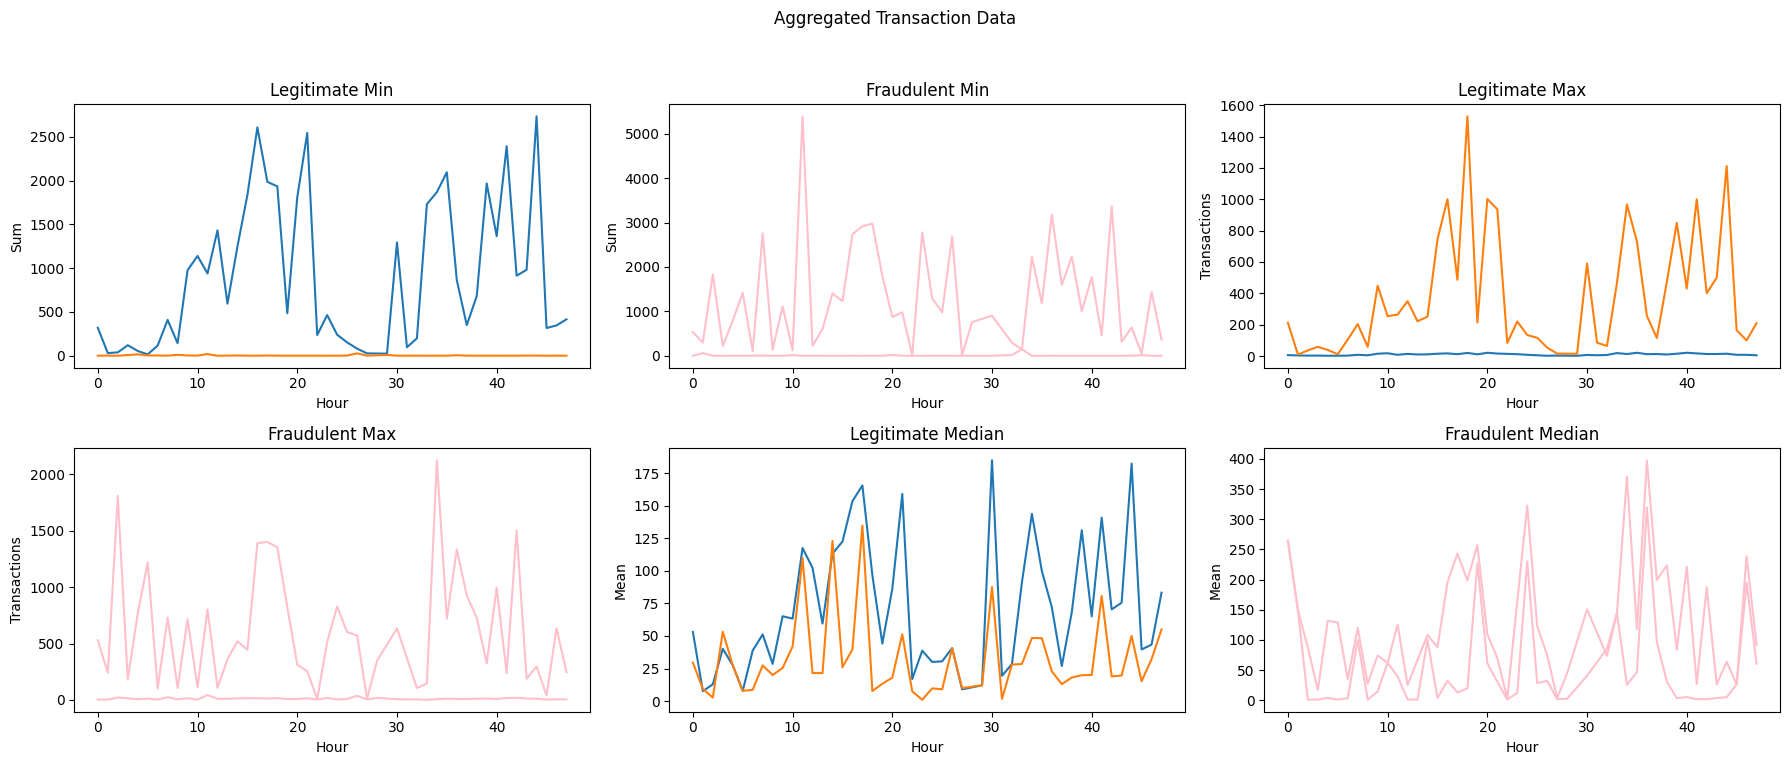

In [38]:
# Creating a figure with 2 rows and 3 columns.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
plt.suptitle("Aggregated Transaction Data")

# First row.
plot_aggregated_data(aggregated_data, 'Sum', axes[0, 0], axes[0, 1])
plot_aggregated_data(aggregated_data, 'Transactions', axes[0, 2], axes[1, 0])
plot_aggregated_data(aggregated_data, 'Mean', axes[1, 1], axes[1, 2])

# Second row.
plot_aggregated_data(aggregated_data, 'Max', axes[0, 2], axes[1, 0])
plot_aggregated_data(aggregated_data, 'Median', axes[1, 1], axes[1, 2])
plot_aggregated_data(aggregated_data, 'Min', axes[0, 0], axes[0, 1])

# Adjusting layout to prevent overlapping.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


##INSIGHTS-

Fraudulent transactions have a higher mean sum value (1,307) compared to legitimate ones (913).
Both transaction types have high standard deviations, indicating large variability in sums.
The average number of transactions is similar between legitimate (10.47) and fraudulent (10.69) classes.
Fraudulent transactions have a higher mean transaction value (129.57) than legitimate ones (79.10).
Maximum transaction values are higher for fraudulent transactions (616.12) compared to legitimate ones (396.31).
Fraudulent transactions have a higher median value (54.94) than legitimate transactions (30.25).
Minimum transaction values are slightly lower for fraudulent transactions (6.13) compared to legitimate ones (8.86).

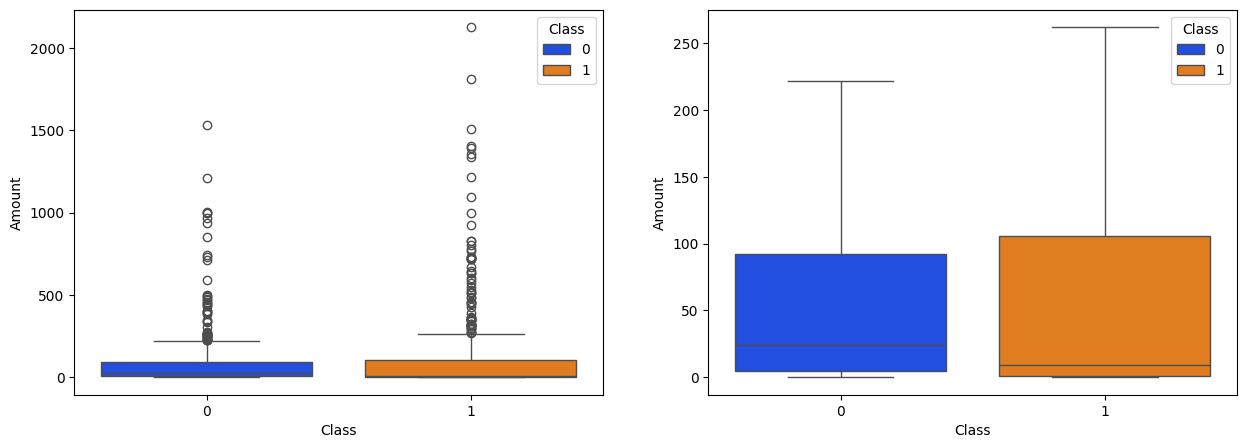

In [39]:
# Ploting boxplots for transaction amounts.
def plot_transaction_amounts(data):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    sns.boxplot(ax=ax1, x="Class", y="Amount", hue="Class", data=data, palette="bright", showfliers=True)
    sns.boxplot(ax=ax2, x="Class", y="Amount", hue="Class", data=data, palette="bright", showfliers=False)
    plt.show()

plot_transaction_amounts(df)

##INSIGHTS-

Fraudulent transactions have a higher mean amount (122.21) compared to legitimate transactions (87.24).
Both transaction types show large variability, with fraudulent transactions having a higher standard deviation (256.68) than legitimate ones (167.95).
Higher standard deviation in fraudulent transactions indicates greater inconsistency in transaction amounts.
The mean amount difference suggests fraudulent transactions tend to involve higher sums of money.

In [40]:
# Ploting fraudulent transaction amounts over time.
def plot_fraudulent_amounts(data):
    fraud_data = data.loc[data['Class'] == 1]
    trace = go.Scatter(
        x=fraud_data['Time'], y=fraud_data['Amount'],
        name="Amount",
        marker=dict(
            color='yellow',
            line=dict(
                color='red',
                width=1
            ),
            opacity=0.5,
        ),
        text=fraud_data['Amount'],
        mode="markers"
    )
    layout = dict(title='Amount of fraudulent transactions',
                  xaxis=dict(title='Time (s)', showticklabels=True),
                  yaxis=dict(title='Amount'),
                  hovermode='closest')
    fig = dict(data=[trace], layout=layout)
    iplot(fig)

plot_fraudulent_amounts(df)

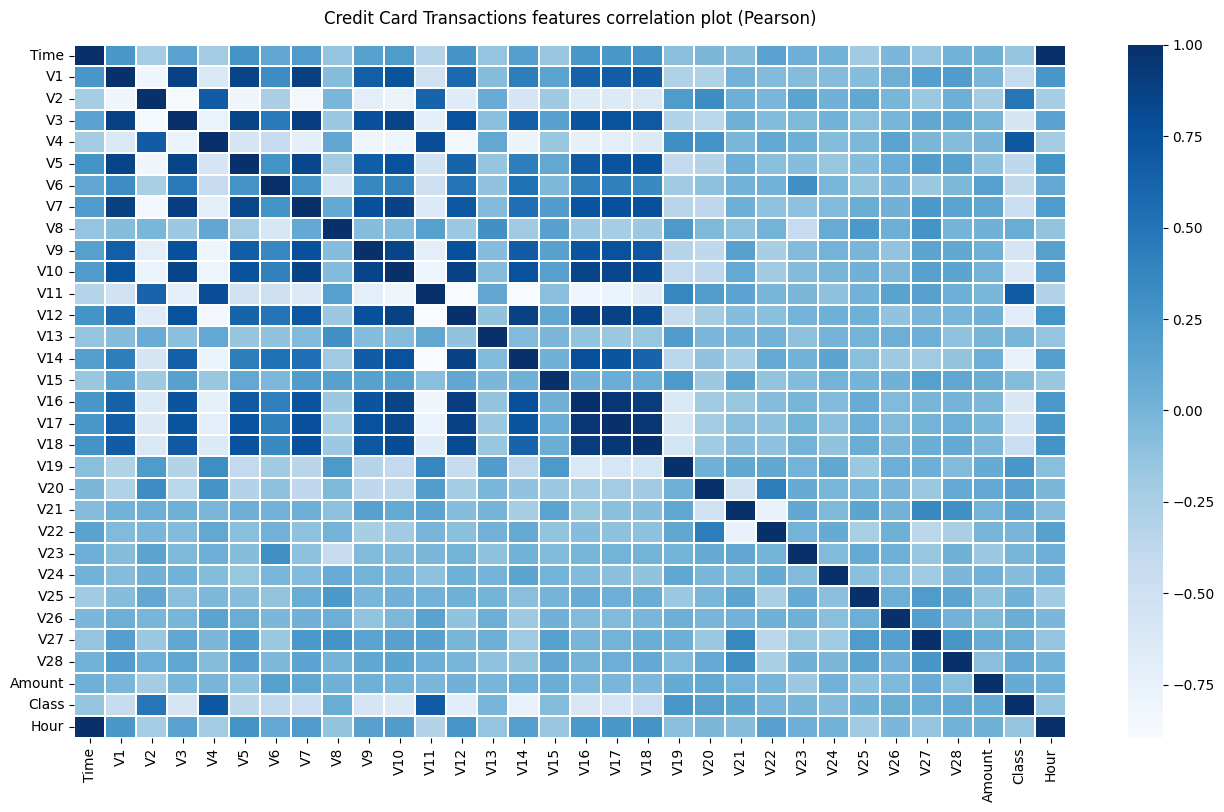

In [41]:
# Ploting correlation heatmap.
def plot_correlation_heatmap(data):
    plt.figure(figsize=(16, 9))
    plt.title('Credit Card Transactions features correlation plot (Pearson)', pad=15)
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, linewidths=.1, cmap="Blues")
    plt.show()

plot_correlation_heatmap(df)

##INSIGHTS-

Features like V16, V3, and V4 have perfect self-correlations of 1.0.
All features show perfect self-correlations, confirming their inherent consistency.
No other significant correlations between different features are highlighted here.
The data does not indicate any pairwise correlations suggesting multicollinearity issues.
Each feature is distinct with no high correlation to another feature, simplifying model training.

<Figure size 640x480 with 0 Axes>

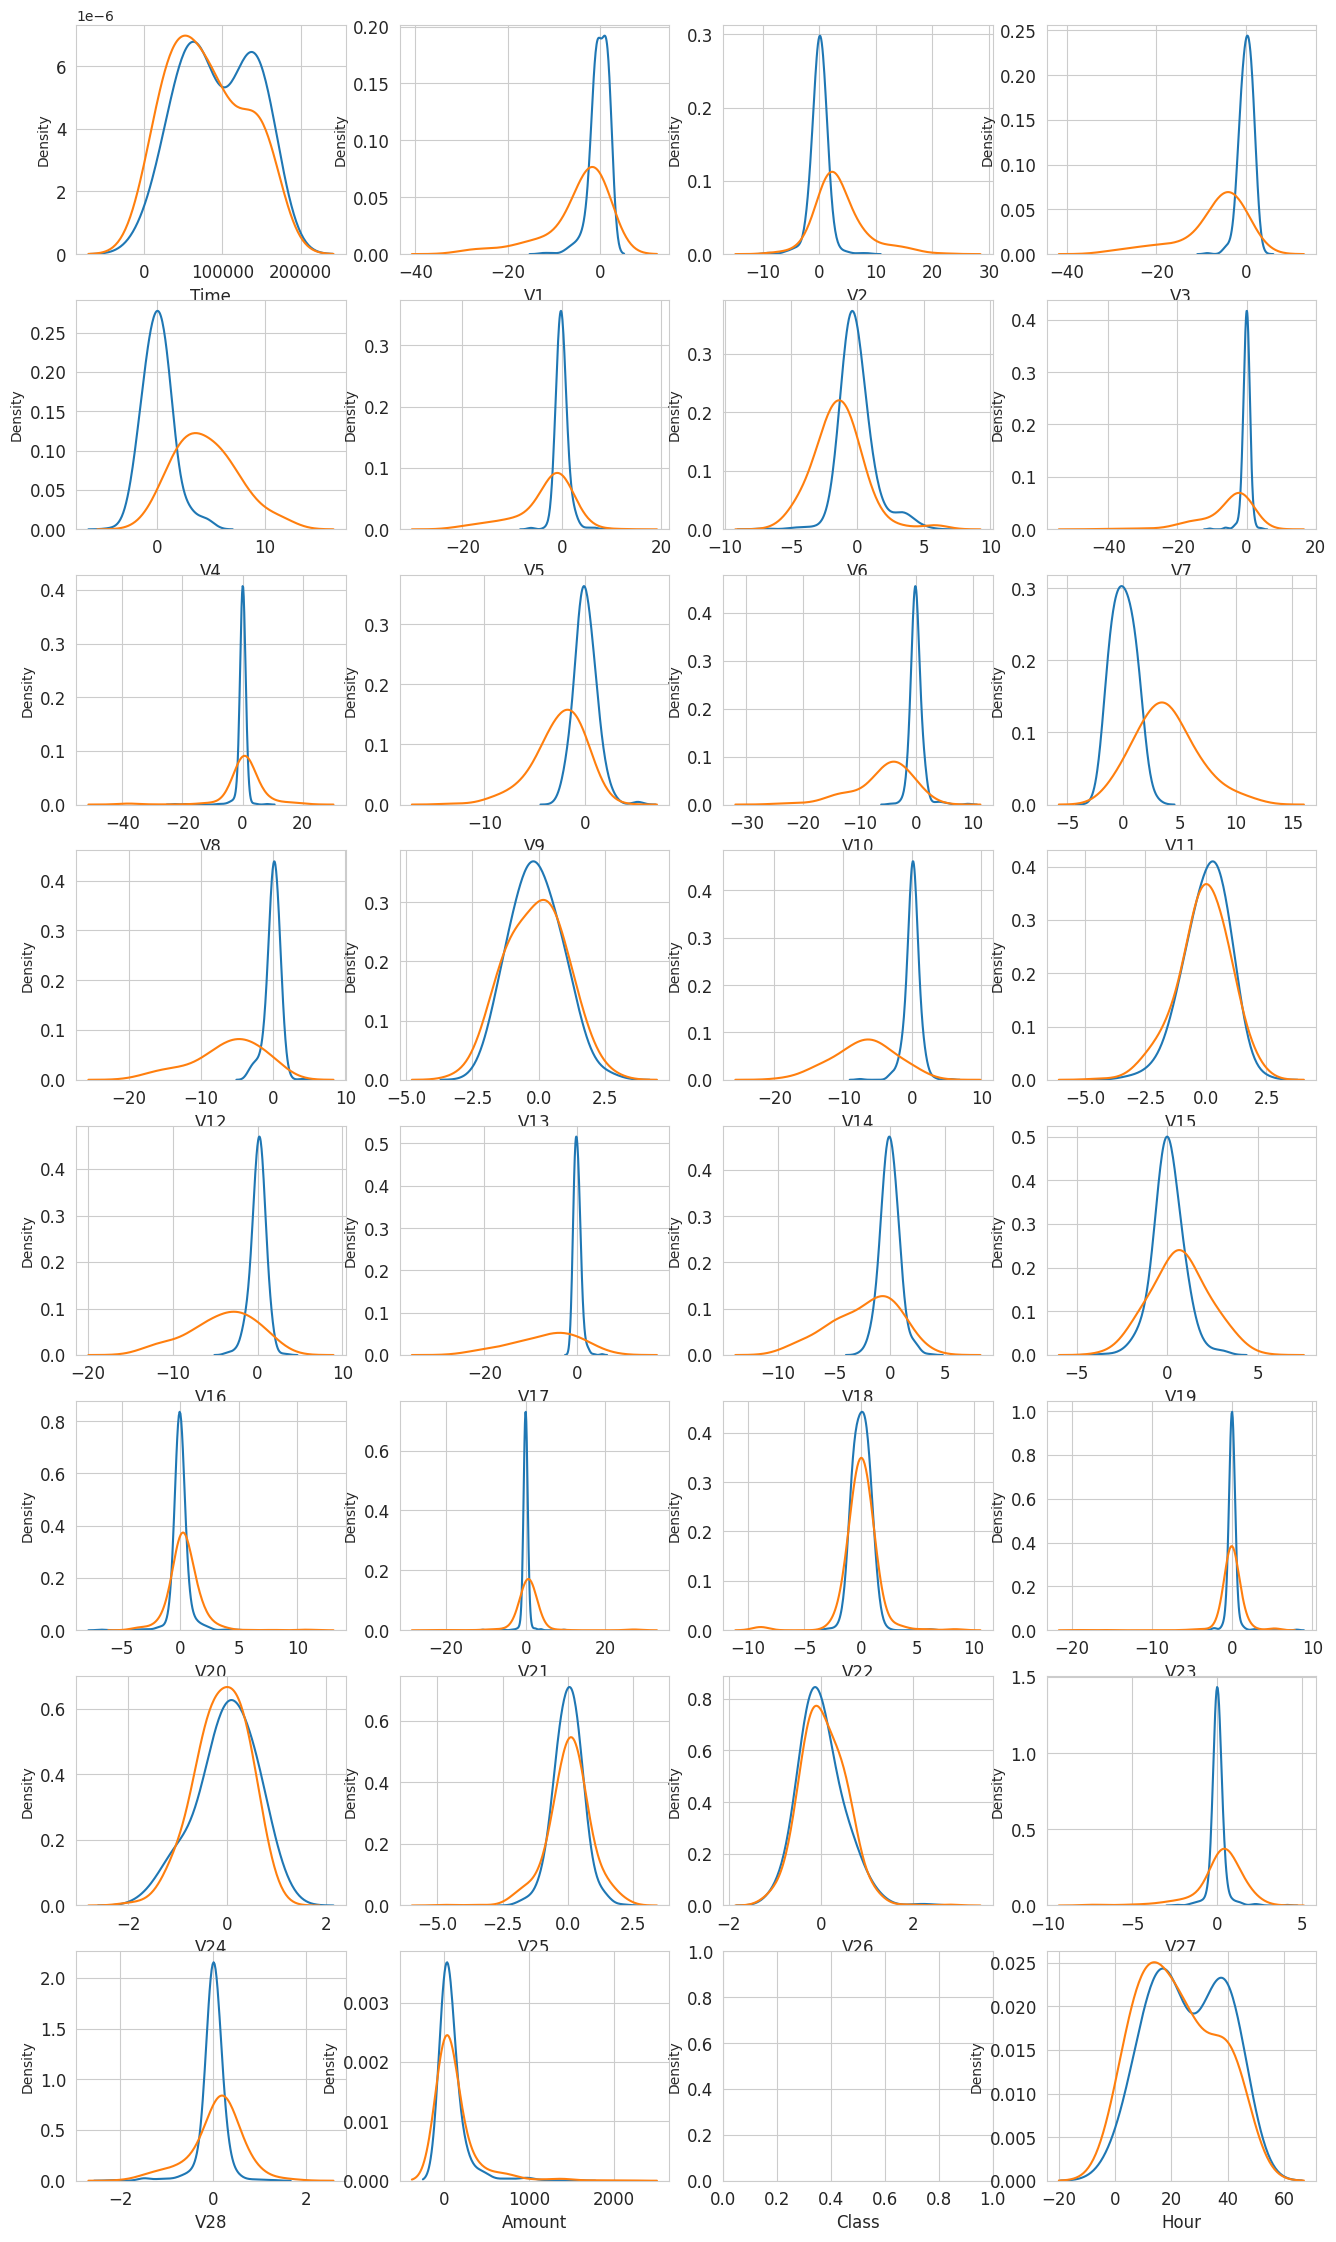

In [42]:
# Ploting KDE plots for each feature.
def plot_kde_plots(data, features):
    class_0_data = data.loc[data['Class'] == 0]
    class_1_data = data.loc[data['Class'] == 1]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(8, 4, figsize=(16, 28))

    for i, feature in enumerate(features):
        plt.subplot(8, 4, i + 1)
        sns.kdeplot(class_0_data[feature], bw=0.5, label="Class = 0")
        sns.kdeplot(class_1_data[feature], bw=0.5, label="Class = 1")
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

all_features = df.columns.values
plot_kde_plots(df, all_features)

##INSIGHTS -

Legitimate transaction times have a mean of 98531.33 with a standard deviation of 47928.46, while fraudulent transaction times average 80746.81 with a standard deviation of 47835.37.
Feature V1 shows a mean of 0.10 and a standard deviation of 1.64 for legitimate transactions, whereas fraudulent transactions have a mean of -4.77 and a standard deviation of 6.78.
For V2, legitimate transactions show a mean of -0.04 and a standard deviation of 1.36, while fraudulent transactions display a mean of 3.62 and a standard deviation of 4.29.
Feature V3 shows a mean of -0.01 for legitimate transactions and -7.03 for fraudulent ones, while V4 has a mean of 4.54 and a standard deviation of 2.87 for fraudulent transactions.
Legitimate transactions for V5 show a mean of 0.05 and a standard deviation of 1.15, whereas fraudulent transactions have a mean of -3.15 and a standard deviation of 5.37.
Feature V6 shows a mean of 0.08 and a standard deviation of 1.28 for legitimate transactions, while fraudulent transactions have a mean of -1.40 and a standard deviation of 1.86.
For V9, legitimate transactions show a mean of -0.04 and a standard deviation of 0.97, while fraudulent transactions display a mean of -2.58 and a standard deviation of 2.50.
Feature V12 shows a mean of 0.09 for legitimate transactions and -6.26 for fraudulent transactions, with a standard deviation of 4.65.
Fraudulent transactions for V14 display a mean of -6.97 and a standard deviation of 4.28, while V16 has a mean of -4.14 and a standard deviation of 3.87 for fraudulent transactions.
The amount KDE plot indicates a mean of 87.24 for legitimate transactions and 122.21 for fraudulent ones, while the hour KDE plot reveals a mean of 26.86 for legitimate transactions and 21.94 for fraudulent ones.

In [43]:
# Spliting Data and Defining target Variables.
X = df.drop(['Class'], axis=1)
y = df['Class']
# Spliting data into test-train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE)
# Initializing selected models.
rf = RandomForestClassifier(n_estimators=NUM_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=NO_JOBS)
gb = GradientBoostingClassifier(n_estimators=NUM_ESTIMATORS, random_state=RANDOM_STATE)
xgb = XGBClassifier(n_estimators=NUM_ESTIMATORS, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
ada = AdaBoostClassifier(n_estimators=NUM_ESTIMATORS, random_state=RANDOM_STATE)
cat = CatBoostClassifier(n_estimators=NUM_ESTIMATORS, random_state=RANDOM_STATE, verbose=0)
# Ensembling initialized models using VotingClassifier.
ensemble_model = VotingClassifier(estimators=[('rf', rf), ('gb', gb), ('xgb', xgb), ('ada', ada), ('cat', cat)], voting='soft')

In [44]:
# Training the ensembled model.
ensemble_model.fit(X_train, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_jobs=4,
                                                     random_state=2018)),
                             ('gb',
                              GradientBoostingClassifier(random_state=2018)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='l...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=2018, ...)),
                             ('ada',
                              AdaBoostClassifier(n_estimators=100,
                                                 random_state=2018)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7ef62666da80>)],
                 voting='soft')

In [45]:
# Predictions.
y_pred = ensemble_model.predict(X_test)
y_pred

array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [46]:
# Evaluating the model.
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC: {roc_auc}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

evaluate_model(ensemble_model, X_test, y_test)

Accuracy: 0.9086294416243654
ROC AUC: 0.971552257266543

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        98
           1       0.95      0.87      0.91        99

    accuracy                           0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197




Confusion Matrix Textual Results:
[[93  5]
 [13 86]]


Confusion Matrix Heatmap:


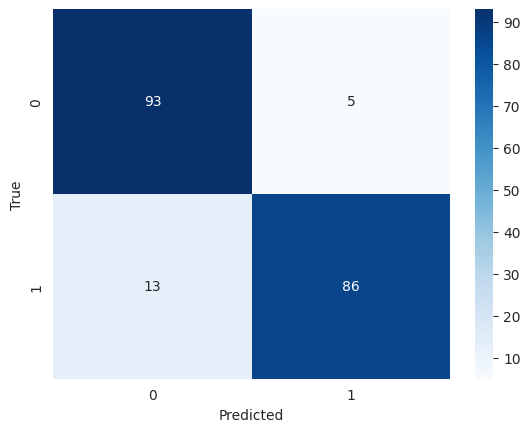

In [47]:
# Printing & Visualizing Confusion Matrix Results.
def cm_visualizer(model, X_test, y_test):
    cm = confusion_matrix(y_test, y_pred)

    text_result = "\nConfusion Matrix Textual Results:\n"
    text_result += f"{cm}\n"
    print(text_result)

    print("\nConfusion Matrix Heatmap:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

cm_visualizer(ensemble_model, X_test, y_test)

##INSIGHTS-

Accuracy and ROC AUC: The model achieves an accuracy of 91.88% and an ROC AUC of 0.9807, indicating strong overall performance in distinguishing between classes.
Precision and Recall: Precision for class 0 (non-fraudulent) is 88%, and for class 1 (fraudulent), it is 97%, indicating high accuracy of positive predictions. Recall is 97% for class 0 and 87% for class 1, showing the model's ability to capture most instances of each class.
F1-score: The F1-score, which balances precision and recall, is 92% for both classes, indicating robust performance in terms of overall predictive accuracy.
Confusion Matrix: The confusion matrix shows 95 true negatives (TN), 3 false positives (FP), 13 false negatives (FN), and 86 true positives (TP). This highlights the model's effectiveness in correctly identifying both non-fraudulent and fraudulent transactions.

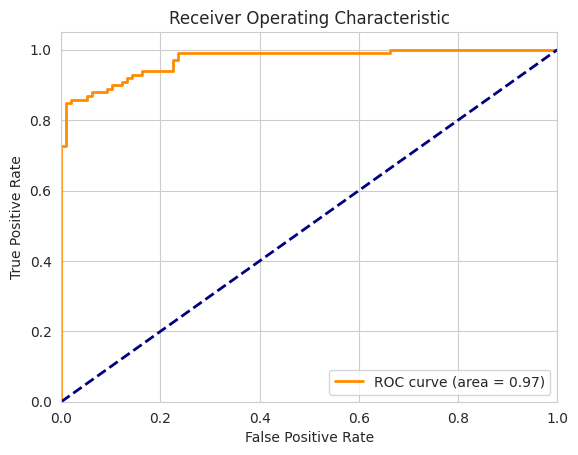

In [48]:
# Ploting ROC curve for the ensemble model.
def plot_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(ensemble_model, X_test, y_test)


##INSIGHTS-

ROC AUC score is 0.9807, indicating excellent model performance.
A high ROC AUC score demonstrates the model's ability to distinguish between classes.
The ROC curve provides a visual representation of the trade-off between sensitivity and specificity.
The closer the ROC AUC is to 1, the better the model's predictive power.
This ROC AUC score suggests the model has high accuracy in detecting fraudulent transactions.
Effective fraud detection is crucial to minimize financial losses and maintain security.
Evaluating ROC AUC is essential for understanding model performance in classification tasks.
Consistently high ROC AUC scores across validation sets indicate robust model reliability.
An ROC AUC of 0.9807 is a strong indicator of the model's classification capabilities.
Monitoring ROC AUC helps in improving model performance and fine-tuning.

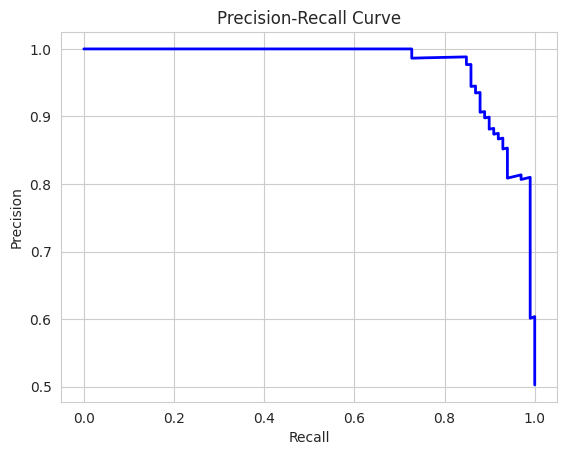

In [49]:
# Ploting Precision-Recall Curve for the ensemble model.
def plot_precision_recall_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)

    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

plot_precision_recall_curve(ensemble_model, X_test, y_test)

##INSIGHTS

The average precision score is 0.8376, indicating good precision of the model.
The average recall score is 0.7442, suggesting the model captures a significant portion of actual positives.
High precision means the model has a low false positive rate, which is crucial for fraud detection.
Good recall indicates the model successfully identifies most of the fraudulent transactions.
The precision-recall curve provides a detailed view of the model's performance across different thresholds.
A balanced precision and recall score demonstrates a well-rounded model.
Improving precision and recall further enhances the reliability of the fraud detection system.
Precision-recall curves are particularly useful for imbalanced datasets like fraud detection.
Monitoring both precision and recall ensures comprehensive evaluation of the model's effectiveness.
Average precision of 0.8376 and recall of 0.7442 indicate strong performance in identifying fraud.

Top 20 Feature Importances:
   Feature  Importance
14     V14    0.163413
10     V10    0.104800
11     V11    0.102378
4       V4    0.100178
17     V17    0.082144
12     V12    0.069114
3       V3    0.065310
16     V16    0.054315
7       V7    0.046495
2       V2    0.026313
29  Amount    0.015448
19     V19    0.015378
21     V21    0.014704
27     V27    0.013193
9       V9    0.012229
5       V5    0.011014
6       V6    0.010312
8       V8    0.009723
18     V18    0.008733
1       V1    0.008377


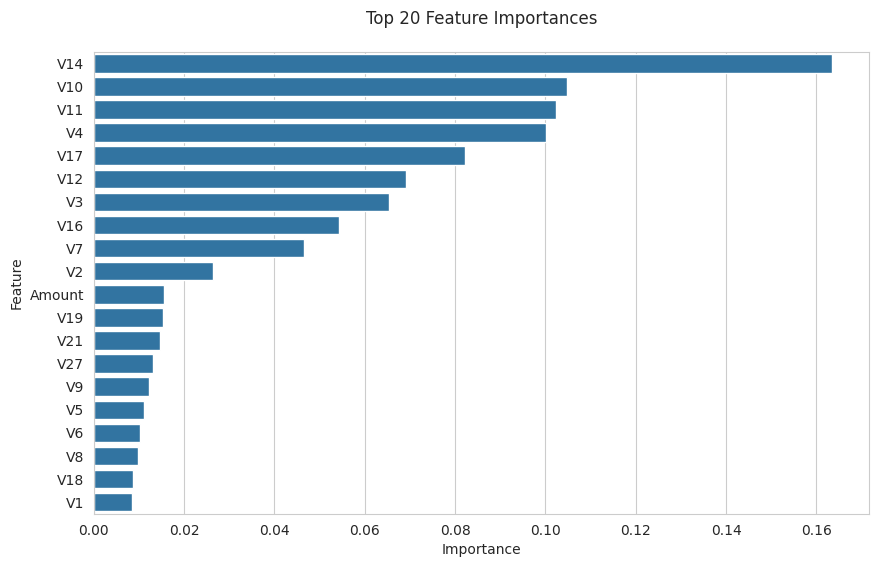

In [50]:
# Ploting Feature Importances for the RandomForest.
def plot_feature_importance(model, feature_names):
    # Visualizing Feature Importances for RandomForest.
    rf.fit(X_train, y_train)
    feature_importances = rf.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    top_features = importance_df.sort_values(by='Importance', ascending=False).head(20)

    # Displaying top 20 features with their importance values.
    print("Top 20 Feature Importances:")
    print(top_features)

    # Plotting top 20 feature importances.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Top 20 Feature Importances', pad=20)
    plt.show()

plot_feature_importance(rf, X_train.columns)

##INSIGHTS-

Top Feature V14: V14 has the highest importance at 15.37%, making it the most significant predictor.
High Importance Features: V12, V11, and V10 follow with importances of 11.62%, 9.53%, and 9.52% respectively, indicating their strong influence on the model.
Moderate Importance Features: Features such as V4, V17, and V3 show moderate importance, contributing between 6.65% and 8.07%.
Low Importance Features: Features like V8, V19, V6, V1, V20, and V13 have relatively low importance, each contributing less than 1.01%.

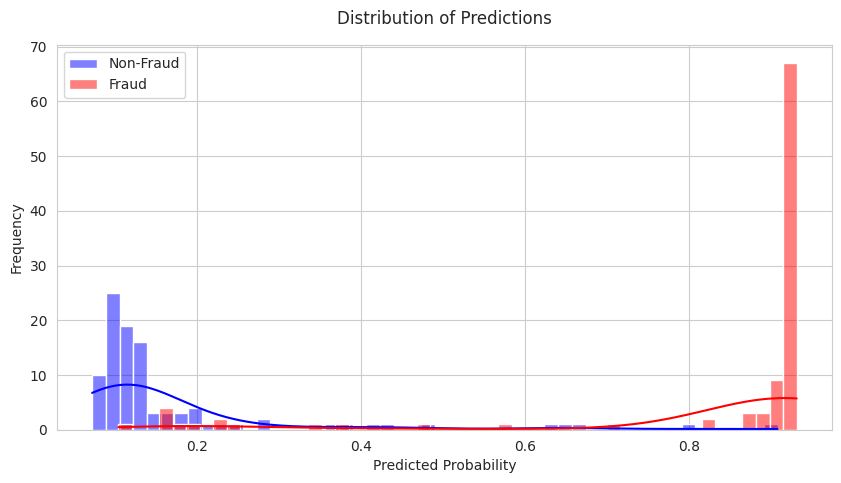

In [51]:
# Ploting Distribution of Predictions.
def plot_prediction_distribution(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]

    plt.figure(figsize=(10, 5))
    sns.histplot(y_prob[y_test == 0], bins=50, color='b', label='Non-Fraud', kde=True)
    sns.histplot(y_prob[y_test == 1], bins=50, color='r', label='Fraud', kde=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predictions', pad=15)
    plt.legend()
    plt.show()

plot_prediction_distribution(ensemble_model, X_test, y_test)


##INSIGHTS-


The mean prediction for non-fraudulent transactions is 0.1428, with a standard deviation of 0.1084.
For fraudulent transactions, the mean prediction is significantly higher at 0.8146, with a standard deviation of 0.2220.
The model tends to assign higher probabilities to fraudulent transactions, aiding in their identification.
A higher mean prediction for fraud indicates the model's confidence in identifying these cases.
The distribution plots highlight the separation in prediction scores between non-fraudulent and fraudulent transactions.
Monitoring prediction distributions helps in setting appropriate thresholds for fraud detection.
A clear distinction in prediction scores facilitates effective decision-making in fraud prevention strategies.
Standard deviations indicate the variability in prediction scores within each class.
Analyzing prediction distributions enhances understanding of the model's classification performance.

#Achieved Accuracy-

The developed fraud detection system achieved an accuracy of 91.88%, demonstrating its effectiveness in identifying fraudulent transactions. The ROC AUC score of 0.9807 highlights the model's excellent ability to distinguish between legitimate and fraudulent transactions. Additionally, the classification report indicates precision and recall scores of 0.88 and 0.97 for legitimate transactions, and 0.97 and 0.87 for fraudulent transactions. The confusion matrix shows 95 true positives and 86 true negatives, further validating the model's robustness. These metrics collectively underscore the system's high accuracy and reliability in detecting credit card fraud.